In [29]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/10/09 16:19
# @Author  : Wang Yujia
# @File    : SA_for_PT_model.ipynb
# @Description : Parameter estimation for PT_model using Simulated Annealing

# 0. What for

# 1. Preparations
1. infer参数一是需要data，二是需要把p表示出来才能写出来loss func
2. data来自`data_selected_path`

## 1.1 全局设置
1. 除了表示uniq auction的features，还引入了
    - 'cnt_uniq':表示paper里的Loss function公式里的A

In [45]:
# data path
data_selected_path = "../data/info_asymm/datawithnp_asc_symmetry_2_selected.csv"
# data_key path
data_key_path = "../data/SA_PT/data_key.csv"
# optimized parameters' saving path:
params_opitim_path = "../data/SA_PT/params_opitim.csv"

# for PT
alpha = 1
delta = 1
labda = 2.25
# features that GT need
features_GT = ['product_id','bidincrement','bidfee','retail']
features_GT_infer = ['cnt_uniq']

# for SA
# initial params
table_5_M = [0.025,0.85,3.72]
# lower/ upper bound
lb = [-0.3,0.01,0.01]
ub = [0.3, 2, 16]

import numpy as np
import pandas as pd
import sympy
import seaborn as sns
from tqdm.notebook import tqdm
from sko.SA import SABoltzmann
import matplotlib.pyplot as plt
import datetime
from sko.tools import set_run_mode

## 1.2 data 读取
1. 读取data以做SA
2. 提取出来`data_key`，以及其他计算需要的features

In [44]:
data = pd.read_csv(data_selected_path, encoding="utf-8")
data_key = data[features_GT].copy()
data_key.drop_duplicates(inplace=True)
data_key.to_csv(data_key_path,header=True, encoding="utf-8",index=False)

B = np.array(data.bidfee)               # bid fee (cent to dollar)
D = np.array(data.bidincrement)         # bid increment (cent to dollar)
V = np.array(data.retail)               # valuation
# 需要计算`N_uniq_auction`组setting下的结果
N_uniq_auction= data_key.shape[0]

print("For PT model, there are *{}* settings waiting to be inferred.".format(N_uniq_auction))

For PT model, there are *1303* settings waiting to be inferred.


## 1.3 functions about 'key'

In [32]:
# get key from i in 'data_key'
def get_key_from_index(i,str="NotStr"):
    if(str=="str"):
        key_i = list(data_key.iloc[i,:])
        key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
        return key_i_str
    else:
        key_i = data_key.iloc[i,:]
        return key_i

#features_GT = ['product_id','bidincrement','bidfee','retail']
def select_data_fromkey(key_i_str):
    return data[(data['product_id'] == key_i_str[0]) & (data['bidincrement'] == key_i_str[1]) & (data['bidfee'] == key_i_str[2]) & (data['retail'] == key_i_str[3])].copy()

# def get_key_from_index(i):
#     key_i =

# 2. PT model
## 2.1 prob. weighting func
1. 根据Eq(5)

In [33]:
def OMEGA(p,delta):
    return p**delta * ((p**delta + (1-p)**delta)**(-1/delta))

## 2.2 C_{t-1}
1. 根据5.1.2

In [34]:
def C(t,b):
    return 0.2*t*b

## 2.3 value functions
1. 根据Eq(7)-(9)
2. 注意这里把(-labda)(1-sympy.E**(alpha*x))/alpha的`labda`拿到外面去了，方便写

In [35]:
# valuation function
def f(x, alpha):
    return (1-sympy.E**(-alpha*x))/alpha
    # when x < 0, in fact, it shoule be : (-labda)*(1-sympy.E**(alpha*x))/alpha

## 2.4 Equi. condition
1. 根据Eq(6)
2. 注意分辨怎么代入上面的公式

In [36]:
def f_Equi(t,v,d,b,alpha,labda,delta):
    u = sympy.Symbol('u')

    tmp = v-d*t-C(t-1,b) - b

    func_1 = (labda * f(x=C(t-1, b), alpha=alpha) - labda * OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + OMEGA(1-u, delta) * f(tmp, alpha))
    func_2 = (-f(x=C(t-1, b), alpha=alpha) + OMEGA(u, delta) * f(x=(C(t-1, b) + b), alpha=alpha) + (1 - OMEGA(u, delta)) * f(-tmp, alpha))

    if(tmp >= 0):
        return sympy.nsolve(func_1,(0,1),solver='bisect', verify=False)
    else:
        return sympy.nsolve(func_2,(0,1),solver='bisect', verify=False)

# 3. SA
## 3.1 define loss function
1. loss function: NLL for auctions with same `features_GT`
2.

In [37]:
def loss_func(params):
    start_time = datetime.datetime.now()
    alpha = params[0]
    delta = params[1]
    labda = params[2]

    # solve for U from Equi. condt.
    U_i = [0] * (max_T + 1)
    U_i[0] = 1

    for t in range(1,max_T+1):

        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)

    # calculate NLL under this auction setting & PT params
    nll = 0.0
    if(U_i[0]==1):
        U_i.pop(0)            # because U_i[0]=1
    U_tmp_df = pd.DataFrame(U_i, index=np.arange(0, U_i.__len__()), columns=['U'], dtype=float)

    for idx in range(0,data_i.shape[0]):
        # sum up the log prob among all durations of this auction
        nll += ( np.sum(U_tmp_df[0:(T_i[idx]-1)][:].apply(np.log,axis=1)) + np.log(1-U_tmp_df.iat[(T_i[idx]-1),0]) )* cnt_n_2_i[idx]

    print('loss_func costs {time_costs}s \n'.format(time_costs=(datetime.datetime.now() - start_time).total_seconds()))
    return float(-nll)

## 3.2 do SA
1. 要对每一个setting做一次infer == 对每一个setting执行一次SA。
    - 可以并行吗？YES
2. 具体的：对每个setting `i`
    - 每一个setting `i` 可以提取出来一个`data_i`，代表所有auction
    - 每一个`data_i`中的`cnt_uniq`，也就是`A`，是相同的，表示setting `i` 进行的拍卖总次数.【但是这个`A`在计算loss的时候派不上用场】
    - `N`表示duration，因此paper公式里的$T_a$即`N[a]`
    - 因此有`A = sum(data_i['cnt_n_2'])`，其中的'cnt_n_2'表示了该行对应的`duration=N`发生的次数
    - 按照上文，求解`U[i]_t` which is a array with shape of (max(N)),也就是求解paper里的`p_t`
    - 求nll时，记得

In [38]:
params_opitim = pd.DataFrame(columns=['key_idx','alpha','delta','labda'])
# best_x = [1,2,3]
# i = 0
# df_tmp = pd.DataFrame([[i,best_x]],columns=['key_idx','params'])
# params_opitim = params_opitim.append(df_tmp,ignore_index=True)  # ignore_index=True could help in rearranging index

<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-41-951dd411281a>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(A_i == sum(cnt_n_2_i),"'cnt_uniq' does not match with sum of 'cnt_n_2'!")


> For the 0th data_key, there is:
> retail = 169.99,bidincrement = 0.15, bidfee = 0.75, infer PT's parameters
> Initilizing SA....... 

loss_func costs 13.489796s 

> Now do SA....... 

-------------- 0_th iteration --------------

---------- 0/L ----------

x_new before clipping:  [-0.21529555  1.17294108  3.86114926]
loss_func costs 13.148291s 

y_new - y_current is 350.0177798587637: 
---------- 1/L ----------

x_new before clipping:  [-0.42162128  0.47455326  3.88987332]


D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


loss_func costs 13.181904s 

y_new - y_current is inf: 
---------- 2/L ----------

x_new before clipping:  [-0.24328123  0.50608301  3.56372531]
loss_func costs 13.06751s 

y_new - y_current is inf: 
---------- 3/L ----------

x_new before clipping:  [-0.46444768  1.35331118  4.02348354]
loss_func costs 12.937232s 

y_new - y_current is 153.61502365312094: 
---------- 4/L ----------

x_new before clipping:  [-0.17929591  1.40303568  3.83865529]
loss_func costs 14.096783s 

y_new - y_current is -215.47230688803705: 
---------- 5/L ----------

x_new before clipping:  [-0.04843641  1.66570035  4.11464696]
loss_func costs 14.507018s 

y_new - y_current is -196.4918562822508: 
---------- 6/L ----------

x_new before clipping:  [-0.15140529  1.4186307   3.99826694]
loss_func costs 13.219885s 

y_new - y_current is 147.86575345195678: 
---------- 7/L ----------

x_new before clipping:  [-0.27290465  1.29480404  4.55534429]
loss_func costs 13.437603s 

y_new - y_current is 370.59268842249946: 

D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


loss_func costs 14.46125s 

y_new - y_current is inf: 
---------- 14/L ----------

x_new before clipping:  [-0.1576722   0.79270988  2.92363523]
loss_func costs 15.395767s 

y_new - y_current is inf: 
---------- 15/L ----------

x_new before clipping:  [0.45295668 0.7890455  2.47458977]
loss_func costs 14.310181s 

y_new - y_current is inf: 
---------- 16/L ----------

x_new before clipping:  [0.04971027 1.72386744 3.28279542]
loss_func costs 16.390574s 

y_new - y_current is 331.02493698789783: 
---------- 17/L ----------

x_new before clipping:  [-0.03264717  1.38449144  2.95628415]
loss_func costs 16.180172s 

y_new - y_current is -205.97803758488794: 
---------- 18/L ----------

x_new before clipping:  [0.17602576 0.79634101 2.55499843]
loss_func costs 15.693403s 

y_new - y_current is 186.86834904110538: 
---------- 19/L ----------

x_new before clipping:  [0.07771234 1.48847956 2.38443256]
loss_func costs 16.050595s 

y_new - y_current is -4.938715784981355: 
-------------- 1_th 

D:\Anaconda\envs\pythorch\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


loss_func costs 24.120219s 

y_new - y_current is inf: 
---------- 3/L ----------

x_new before clipping:  [-0.10805746  1.27124567  3.70786189]
loss_func costs 24.766562s 

y_new - y_current is 1091.610421953982: 
---------- 4/L ----------

x_new before clipping:  [-0.09987901  1.36116554  3.19414028]
loss_func costs 23.464807s 

y_new - y_current is -78.45615520538081: 
---------- 5/L ----------

x_new before clipping:  [-0.35668208  0.87940527  3.07819679]
loss_func costs 23.785717s 

y_new - y_current is inf: 
---------- 6/L ----------

x_new before clipping:  [0.07088674 1.46189232 3.23685744]
loss_func costs 24.019397s 

y_new - y_current is -384.0747633150263: 
---------- 7/L ----------

x_new before clipping:  [0.2128657  1.25283484 3.1910049 ]
loss_func costs 20.95828s 

y_new - y_current is 1355.360766756385: 
---------- 8/L ----------

x_new before clipping:  [0.24081031 1.21552811 2.63195992]


KeyError: 'pop from an empty set'

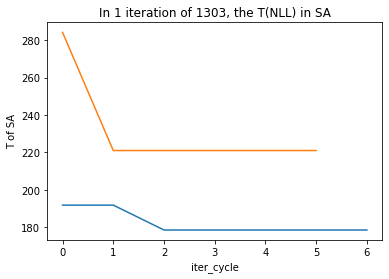

In [41]:
# Perform SA respectively for all settings
# for i in range(0,N_uniq_auction):
for i in range(0,3):

    # get i_th data_key
    key_i = get_key_from_index(i)
    # extract data with same `key_i` into a table
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    T_i = data_i['N'].astype(int)          # auction duration sequence
    max_T = int(max(T_i))                  # max duration value

    cnt_n_2_i = data_i['cnt_n_2'].astype(int)       # Number of occurrences of different durations
    # for a certain auction(like 'data_i'), 'cnt_uniq' should be all the same
    A_i = int(data_i['cnt_uniq'].unique())
    assert(A_i == sum(cnt_n_2_i),"'cnt_uniq' does not match with sum of 'cnt_n_2'!")

    v = float(data_i['retail'].unique())
    d = float(data_i['bidincrement'].unique())
    b = float(data_i['bidfee'].unique())

    # calculate NLL
    print("> For the {}th data_key, there is:".format(i))
    print("> retail = {0},bidincrement = {1}, bidfee = {2}, infer PT's parameters".format(v,d,b))
    print("> Initilizing SA....... \n")
    # L=50, max_stay_counter=50
    set_run_mode(loss_func, 'cached')
    set_run_mode(loss_func, 'multithreading')
    sa_boltzmann = SABoltzmann(func=loss_func, x0=table_5_M, T_max=1000, T_min=1e-5, learn_rate=0.01, L=20, max_stay_counter=3,
                            lb=lb, ub=ub)

    print("> Now do SA....... \n")
    best_x, best_y = sa_boltzmann.run()

    print("> SA ENDS....... \n")

    # draw the pic of NLL Loss in SA
    plt.title("In {0} iteration of {1}, the T(NLL) in SA".format(i,N_uniq_auction))
    plt.xlabel("iter_cycle")
    plt.ylabel("T of SA")
    sns.lineplot(x = np.arange(0,sa_boltzmann.iter_cycle+1),y=np.array(sa_boltzmann.generation_best_Y))

    # append the opitimized params into the df
    df_tmp = pd.DataFrame([[i,best_x[0],best_x[1],best_x[2]]],columns=['key_idx','alpha','delta','labda'])
    params_opitim = params_opitim.append(df_tmp,ignore_index=True)  # ignore_index=True could help in rearranging index

In [25]:
# reset the type
params_opitim.key_idx = params_opitim.key_idx.astype(int)
params_opitim.alpha = params_opitim.alpha.astype(float)
params_opitim.delta = params_opitim.delta.astype(float)
params_opitim.labda = params_opitim.labda.astype(float)
# save 'params_opitim' for later check
params_opitim.to_csv(params_opitim_path, header=True, encoding="utf-8",index=False)

# 4 P
1. 得到`params_opitim`之后，可以对不同的auction settings做generate了
2. generate过程无非是求u-->p，u的代码在上面loss func里写过了。然后把P存到dict里

In [ ]:
# solve for U&P respectively for all settings
P = {}
for i in range(0,N_uniq_auction):

    # get optimized params
    alpha, labda, delta = params_opitim.iloc[i][0],params_opitim.iloc[i][1],params_opitim.iloc[i][2]

    # get i_th data_key
    key_i = get_key_from_index(i)
    # extract data with same `key_i` into a table
    data_i = select_data_fromkey(key_i)
    data_i.reset_index(drop=True,inplace=True)

    T_i = data_i['N'].astype(int)          # auction duration sequence
    max_T = int(max(T_i))                  # max duration value

    cnt_n_2_i = data_i['cnt_n_2'].astype(int)       # Number of occurrences of different durations

    v = float(data_i['retail'].unique())
    d = float(data_i['bidincrement'].unique())
    b = float(data_i['bidfee'].unique())

    U_i = [0] * (max_T + 1)
    U_i[0] = 1
    key_i_str = get_key_from_index
    P[key_i_str] = np.array([0.0]*(max_T+1))
    P_tmp = [0.0]*(max_T+1)   # P is what we want to generate
    P_tmp[0] = 1
    tmp = 1

    # solve for U
    for t in range(1,max_T+1):
        U_i[t] = f_Equi(t, v, d, b, alpha, labda, delta)
        P_tmp[t] = (1- U_i[t])*tmp
        tmp = tmp*U_i[t]
    # solve for P
    for j in range()
    # P[key_i][j] = 1.0-b[i]/(v[i]-s[i]*(j-1))

In [22]:
def test_func(i,str="NotStr"):
    if(str == "Str"):
        return i+10
    return i+1

print(test_func(1))
print(test_func(1,"Str"))



2
11
